In [188]:
# Importing libraries and packages
import geopandas as gpd
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
# Installing xgboost: conda install -c conda-forge xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

# Metrics
from sklearn import metrics

# Feature importance visulization
import shap
from xgboost import plot_importance

### Load the TX/FL datasets and merge them

In [2]:
with open('../data/open-fema/FEMA-Large-DR-4332-TX.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4332 = pd.json_normalize(femaData['fema_open_api'])
with open('../data/open-fema/FEMA-Large-DR-4337-FL.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4337 = pd.json_normalize(femaData['fema_open_api'])
femaData = None

In [3]:
femaDf = pd.concat([femaDf_4332, femaDf_4337])
print('There are {} records combined.'.format(len(femaDf)))

There are 3538955 records combined.


In [95]:
femaDf.columns

Index(['householdComposition', 'specialNeeds', 'homeOwnersInsurance',
       'floodInsurance', 'inspected', 'rpfvl', 'habitabilityRepairsRequired',
       'destroyed', 'waterLevel', 'floodDamage', 'foundationDamage',
       'roofDamage', 'tsaEligible', 'rentalAssistanceEligible',
       'repairAssistanceEligible', 'replacementAssistanceEligible',
       'sbaEligible', 'primaryResidence', 'ownRent_Owner', 'ownRent_Renter',
       'ownRent_Unknown', 'residenceType_Apartment',
       'residenceType_Assisted Living Facility', 'residenceType_Boat',
       'residenceType_College Dorm', 'residenceType_Condo',
       'residenceType_Correctional Facility', 'residenceType_House/Duplex',
       'residenceType_Military Housing', 'residenceType_Mobile Home',
       'residenceType_Other', 'residenceType_Townhouse',
       'residenceType_Travel Trailer', 'residenceType_Unknown', 'haAmount'],
      dtype='object')

### Select a subset of columns

https://docs.google.com/document/d/1nu0yENGAWnoiMcTufxYnH7xwdh8NfFum9ni9IYiSIdk/edit#

In [5]:
cols = ['householdComposition', 'specialNeeds', 'ownRent', 'residenceType', 'homeOwnersInsurance', 'floodInsurance', 
        'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage', 
        'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'rentalAssistanceAmount', 
        'repairAssistanceEligible', 'repairAmount', 'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible', 
        'primaryResidence']
femaDf = femaDf.loc[:, cols]

### Feature Engineering
TODO: Move this out of modeling

In [6]:
# Convert dtype from object to boolean
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')

In [7]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']
femaDf[bool_cols] = femaDf[bool_cols].astype(int)

In [8]:
# One-hot encode the categorical variables
cat_cols = ['ownRent', 'residenceType']
for col in cat_cols:
    femaDf = pd.concat([femaDf, pd.get_dummies(femaDf[col], prefix=col)], axis=1)
femaDf.drop(cat_cols, axis=1, inplace=True)

In [9]:
# Fill the na's with zero's in waterLevel
femaDf['waterLevel'].fillna(0, inplace=True)

In [10]:
# Define all the dollar amount columns
amount_cols = ['rentalAssistanceAmount', 'replacementAmount','repairAmount', 'rpfvl']
# Set them to zero if null
femaDf[amount_cols] = femaDf[amount_cols].fillna(0)
# Calculate the aggregated haAmount
femaDf['haAmount'] = femaDf['rentalAssistanceAmount'] + femaDf['replacementAmount'] + femaDf['repairAmount']

In [11]:
# Drop the individual amount columns
femaDf.drop(['rentalAssistanceAmount', 'replacementAmount','repairAmount'], axis=1, inplace=True)

In [96]:
femaDf.iloc[0]

householdComposition                      1.0
specialNeeds                              0.0
homeOwnersInsurance                       0.0
floodInsurance                            0.0
inspected                                 1.0
rpfvl                                     0.0
habitabilityRepairsRequired               0.0
destroyed                                 0.0
waterLevel                                0.0
floodDamage                               0.0
foundationDamage                          0.0
roofDamage                                0.0
tsaEligible                               1.0
rentalAssistanceEligible                  0.0
repairAssistanceEligible                  0.0
replacementAssistanceEligible             0.0
sbaEligible                               0.0
primaryResidence                          1.0
ownRent_Owner                             0.0
ownRent_Renter                            1.0
ownRent_Unknown                           0.0
residenceType_Apartment           

### Train/Test Split

In [98]:
# Split the data into train and test data
X = femaDf.loc[:, femaDf.columns != 'haAmount']
y = femaDf.loc[:, 'haAmount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2831164, 34) (2831164,)
(707791, 34) (707791,)


### RandomForest

https://machinelearningmastery.com/random-forest-ensemble-in-python/

- The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the size of the training dataset to make the bootstrap sample used to train each decision tree.
- max_features argument and defaults to the square root of the number of input features. 
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default.

In [136]:
# RandomForest default model
model_rf = RandomForestRegressor(random_state = 42)

#### GridSearch

In [139]:
# Create the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_samples': [0.8, 0.9, 1.0],
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100, 150]
}

In [141]:
# Instantiate the grid search model
# scoring='neg_mean_absolute_error'?
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [142]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


One or more of the test scores are non-finite: [0.91534475 0.91530034 0.91526793 0.91478843 0.91506281 0.91513938
        nan        nan        nan 0.94321694 0.94324124 0.94321003
 0.94305385 0.94310892 0.94312421        nan        nan        nan
 0.95031718 0.95039102 0.95036769 0.95033008 0.95036888 0.95034673
        nan        nan        nan]


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 6, 8],
                         'max_samples': [0.8, 0.9, 1.0],
                         'n_estimators': [50, 100, 150]},
             verbose=2)

In [143]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 8, 'max_samples': 0.8, 'n_estimators': 100}

In [144]:
# Predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [145]:
# Look at actual verus predicted
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
1457015,1295.0,1177.795576
585781,0.0,0.000000
571911,0.0,0.000000
1402969,0.0,0.000000
29312,0.0,0.000000
...,...,...
2370904,0.0,0.000000
1712537,0.0,0.000000
890772,0.0,0.000000
1735674,0.0,0.000000


In [146]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# MAPE
errors = abs(y_pred - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: 76.81159646081423
Mean Squared Error: 298559.5102390506
Root Mean Squared Error: 546.4059939633263
Accuracy: 76.55 %


#### Variable Importance using Shapley

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

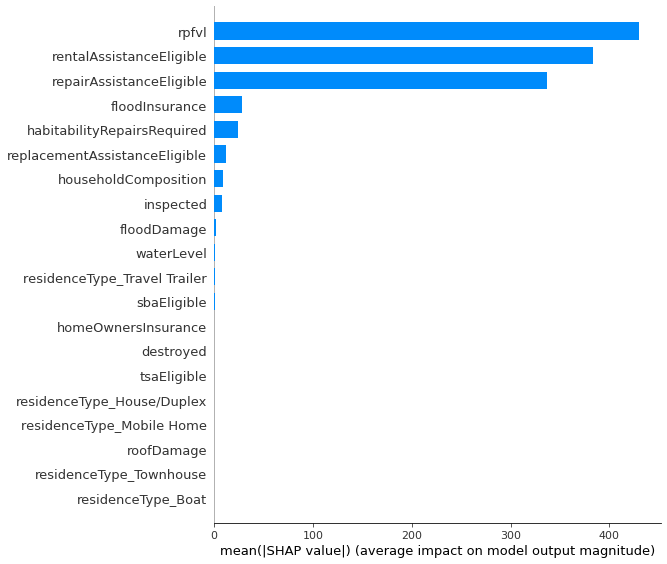

In [132]:
shap_values = shap.TreeExplainer(best_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

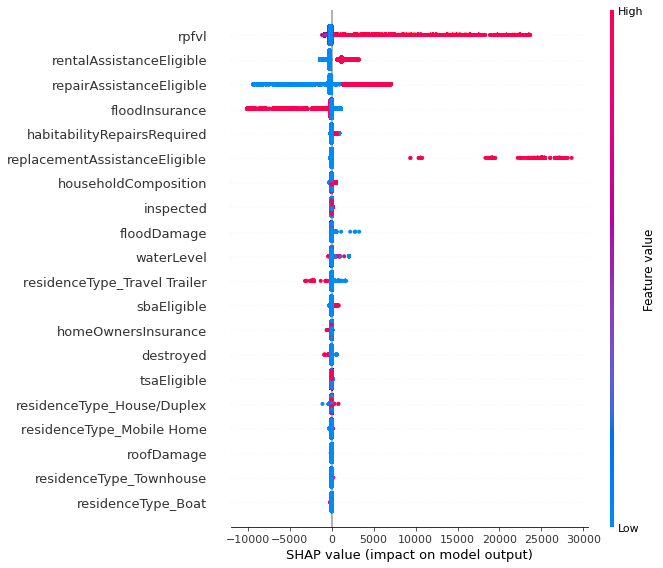

In [133]:
shap.summary_plot(shap_values, X_train)

In [148]:
for score, name in sorted(zip(best_model.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

rpfvl 0.6402476865854471
repairAssistanceEligible 0.24689960628837626
rentalAssistanceEligible 0.0509043653289774
floodInsurance 0.030317495078004623
replacementAssistanceEligible 0.022241011658677163
habitabilityRepairsRequired 0.0042694299712548915
residenceType_Travel Trailer 0.0012351908806708118
householdComposition 0.0010014931576241301
waterLevel 0.0009035925695020983
homeOwnersInsurance 0.0008138921901634199
residenceType_Mobile Home 0.00031058632869563057
sbaEligible 0.00024722250481740664
floodDamage 0.00014697387384602321
residenceType_House/Duplex 0.00011057259044482905
tsaEligible 7.928427298852044e-05
inspected 6.82671138364041e-05
destroyed 4.850466579841843e-05
roofDamage 3.2927729424981284e-05
foundationDamage 3.1863742321565704e-05
residenceType_Boat 2.49752062691068e-05
specialNeeds 2.3920402864020584e-05
residenceType_Townhouse 2.2775975293478978e-05
residenceType_Condo 9.829531725333689e-06
ownRent_Owner 3.611178019778299e-06
residenceType_Apartment 2.0447934925613

### XGBoost 
https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

Hyperparameters:
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- Tree depth is controlled via the “max_depth” argument and defaults to 6.
- The learning rate can be controlled via the “eta” argument and defaults to 0.3.
- The number of samples used to fit each tree is specified by the “subsample” argument and can be set to a fraction of the training dataset size. By default, it is set to 1.0 to use the entire training dataset.
- The number of features used by each tree is taken as a random sample and is specified by the “colsample_bytree” argument and defaults to all features in the training dataset, e.g. 100 percent or a value of 1.0. 

In [151]:
# XGBRegressor default model
model_xgb = XGBRegressor(random_state = 42)

#### GridSearch

In [152]:
# Create the parameter grid
param_grid = {
        'learning_rate': [0.05, 0.1],
        'max_depth': [4, 6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'n_estimators' : [50, 75, 100],
        'objective': ['reg:squarederror']
    }

In [153]:
# Instantiate the grid search model
# scoring='neg_mean_absolute_error'?
grid_search = GridSearchCV(estimator = model_xgb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [154]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [155]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 8,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [157]:
# Predict
model_xgb_best = grid_search.best_estimator_
y_pred = model_xgb_best.predict(X_test)

In [158]:
# Look at actual verus predicted
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
1457015,1295.0,1153.493042
585781,0.0,0.000750
571911,0.0,0.000750
1402969,0.0,0.000750
29312,0.0,0.000750
...,...,...
2370904,0.0,0.000750
1712537,0.0,0.000750
890772,0.0,0.000750
1735674,0.0,0.000750


In [160]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 71.96643963994144
Mean Squared Error: 283631.91520018823
Root Mean Squared Error: 532.5710423973389


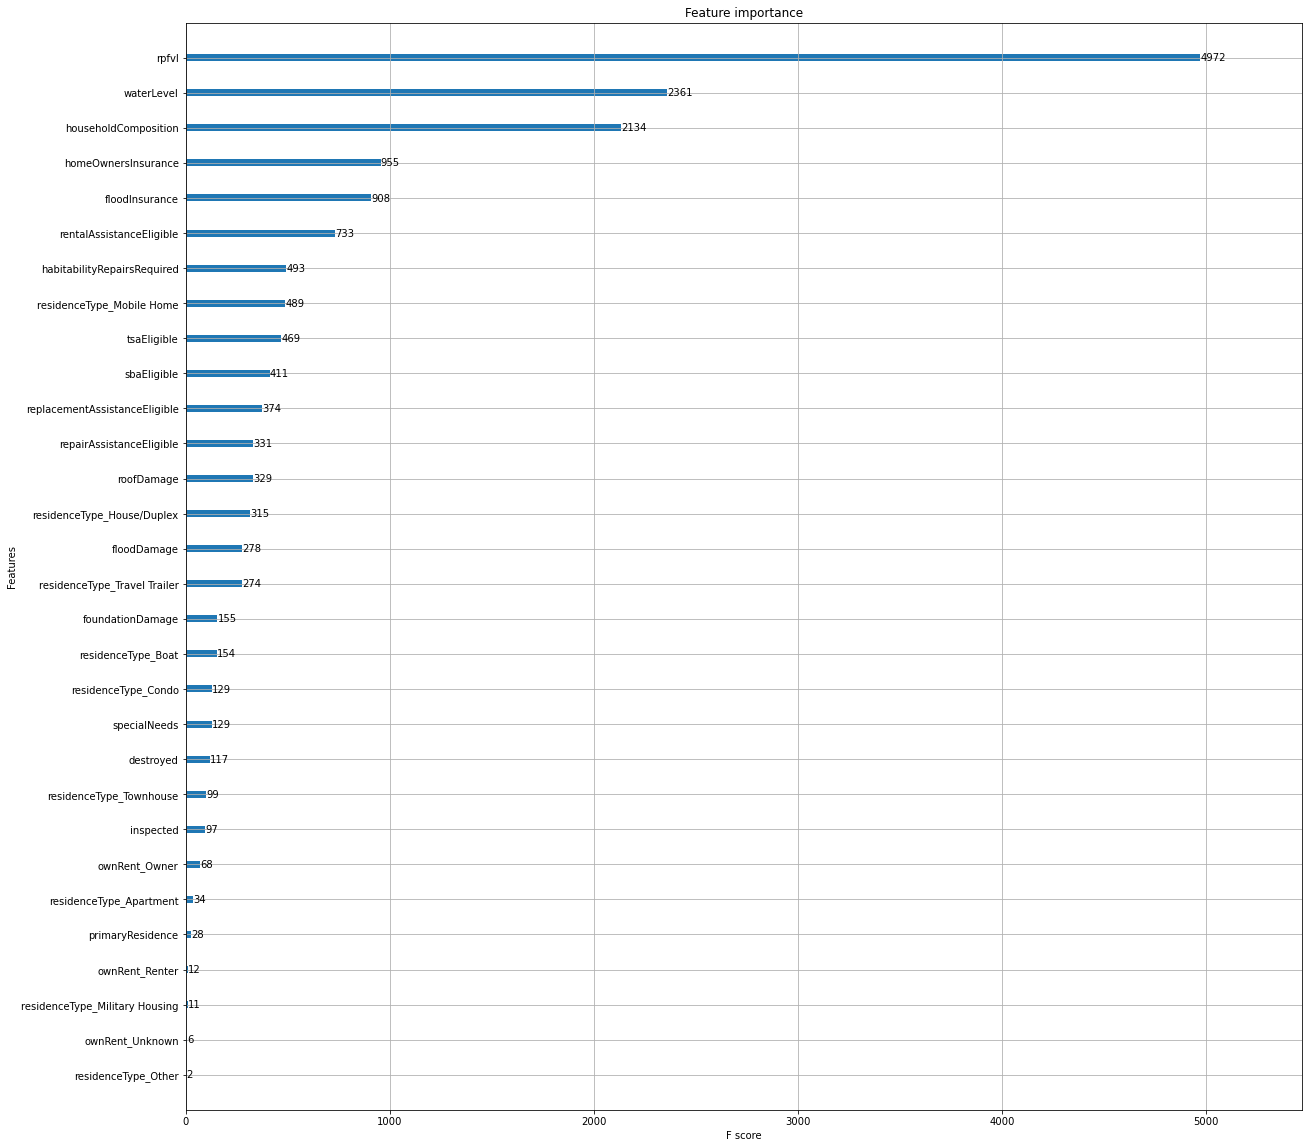

In [189]:
plot_importance(model_xgb_best)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [190]:
for score, name in sorted(zip(model_xgb_best.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

repairAssistanceEligible 0.701973
rpfvl 0.12082439
rentalAssistanceEligible 0.06542414
replacementAssistanceEligible 0.056693103
floodInsurance 0.03165592
habitabilityRepairsRequired 0.008195436
residenceType_Travel Trailer 0.0032930176
homeOwnersInsurance 0.0018538339
residenceType_Mobile Home 0.0010524606
waterLevel 0.00087369443
householdComposition 0.0008249974
sbaEligible 0.0008152591
inspected 0.00079526607
floodDamage 0.00075205555
destroyed 0.0006835648
roofDamage 0.0006644195
residenceType_House/Duplex 0.0005422274
residenceType_Boat 0.00043912686
foundationDamage 0.00038337792
tsaEligible 0.00038327658
specialNeeds 0.00037849526
residenceType_Townhouse 0.00035995684
residenceType_Condo 0.0002950239
residenceType_Other 0.00016732162
ownRent_Unknown 0.00015315777
ownRent_Owner 0.00014428425
residenceType_Apartment 0.00013893736
ownRent_Renter 0.000104509156
primaryResidence 0.000100526966
residenceType_Military Housing 3.5309735e-05
residenceType_Unknown 0.0
residenceType_Corre